# 一、简介
LangGraph是LangChain、LangServe和LangSmith系列的最新成员，旨在使用LLM构建生成式人工智能应用程序。请记住，所有这些都是独立的包，必须单独进行pip安装。

在深入学习LangGraph之前，需要了解LangChain的两个主要概念。

1. 链：围绕LLM编写的程序，用于执行任务，例如自动SQL编写或NER提取链等。请注意，链不能用于任何其他任务（甚至不能用于一般用例），如果尝试这样做，可能会损坏链。链中要遵循的步骤是预定义的，不可灵活调整。

2. 代理：链的更加灵活版本，代理通常是启用第三方工具（例如谷歌搜索、YouTube）的LLM，由LLM本身决定下一步如何解决给定的查询。

现在，当处理现实世界的问题时，一个常见的问题是希望找到介于链和代理之间的解决方案。即不像链那样硬编码，但也不像代理那样完全由LLM驱动。

# 二、LangGraph
LangGraph是以LangChain为核心，用于创建工作流程中的循环图的工具。因此，我们假设以下示例：

你希望在知识库上搭建一个基于RAG的检索系统。现在，你希望引入这样一种情况：如果RAG的输出未满足特定质量要求，代理/链应该再次检索数据，但这次是自行更改提示。并且重复此过程，直到达到质量阈值为止。

使用LangGraph可以实现这种循环逻辑。这只是一个示例，使用LangGraph还可以做更多事情。

注：可以将其视为向链中引入循环逻辑，使其成为循环链。

LangGraph对于构建Autogen或MetaGPT等多代理应用程序至关重要。
顾名思义，LangGraph具有一般图形所具有的所有组件，例如节点、边等，接下来通过一个示例来了解。

# 三、使用LangGraph改善RAG
在此示例中，希望将RAG系统在数据库中的最终输出减少到不超过30个字符。如果输出长度大于30个字符，则希望引入循环，使用不同的提示再次尝试，直到长度小于30个字符为止。这是一个演示目的的基本逻辑。你甚至可以实现复杂的逻辑来改善RAG结果。

我们将创建的图形如下所示。

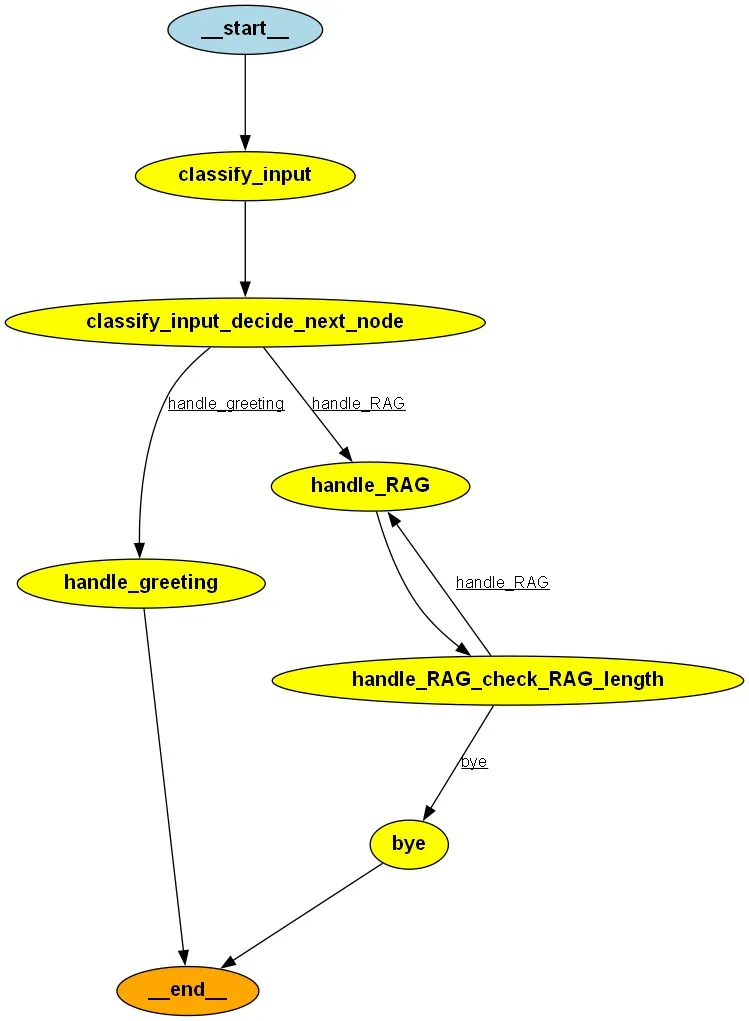

In [ ]:
!pip install langchain openai==1.3.8 langgraph --quiet
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers -U
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet

## 3.1 首先，让我们导入重要的内容并初始化LLM。这里使用的是OpenAI API，但你也可以使用其他LLM。

In [ ]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from typing import Dict, TypedDict, Optional

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langgraph.graph import StateGraph, END
from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

接下来，我们将定义一个StateGraph。

In [ ]:
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None
    length: Optional[int] = None
    greeting: Optional[str] = None

workflow = StateGraph(GraphState)

什么是StateGraph？

StateGraph是任何LangGraph流程的核心，它存储了在执行工作流程时我们将存储的各种变量的状态。在本例中，我们有5个变量，其值在执行图形时将进行更新，并将与所有边和节点共享。

In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

## 3.2 接下来，让我们从现有向量数据库中初始化一个RAG检索链。代码已在以下视频中进行了解释。

In [ ]:
def retriever_qa_creation():
        embeddings
        db = Chroma(embedding_function=embeddings,persist_directory='/database',collection_name='details')
        qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())
        return qa

rag_chain = retriever_qa_creation()

## 3.3 接下来，我们将向该图形添加节点。

In [ ]:
def classify(question):
    return llm("classify intent of given input as greeting or not_greeting. Output just the class.Input:{}".format(question)).strip()

def classify_input_node(state):
    question = state.get('question', '').strip()
    classification = classify(question)
    return {"classification": classification}

def handle_greeting_node(state):
    return {"greeting": "Hello! How can I help you today?"}

def handle_RAG(state):
    question = state.get('question', '').strip()
    prompt = question
    if state.get("length")<30:
         search_result = rag_chain.run(prompt)
    else:
         search_result = rag_chain.run(prompt+'. Return total count only.')

    return {"response": search_result,"length":len(search_result)}


def bye(state):
    return{"greeting":"The graph has finished"}

workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_RAG", handle_RAG)
workflow.add_node("bye", bye)

这需要一些解释。

每个节点都是一个Python函数，它可以：
①读取任何状态变量。

②更新任何状态变量。在这种情况下，每个节点的返回函数都会更新某个或某些状态变量的状态/值。

使用state.get()来读取任何状态变量。

handle_RAG节点可以帮助我们实现我们希望的循环自定义逻辑。如果输出的长度<30，则使用提示符A；否则使用提示符B。对于第一种情况（当RAG节点尚未执行时），我们将传递length=0，并提供一个提示。

## 3.4 接下来，我们将添加入口点和边缘。

In [ ]:
workflow.set_entry_point("classify_input")
workflow.add_edge('handle_greeting', END)
workflow.add_edge('bye', END)

在上述的代码片段中，

我们向图中添加了一个入口点，即无论输入提示是什么，都会执行的第一个节点函数。

A节点和B节点之间的边界定义了在节点A之后执行节点B。在这种情况下，如果在我们的工作流中出现了handle_greeting或bye，则图形应该END（一个特殊的节点来终止工作流）。

## 3.5 接下来，让我们添加条件边界。

In [ ]:
def decide_next_node(state):
    return "handle_greeting" if state.get('classification') == "greeting" else "handle_RAG"

def check_RAG_length(state):
    return "handle_RAG" if state.get("length")>30 else "bye"

workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
    {
        "handle_greeting": "handle_greeting",
        "handle_RAG": "handle_RAG"
    }
)

workflow.add_conditional_edges(
    "handle_RAG",
    check_RAG_length,
    {
        "bye": "bye",
        "handle_RAG": "handle_RAG"
    }
)

条件边界可根据条件（例如if-else）在两个节点之间进行选择。在创建的两个条件边界中：

第一个条件边界

当遇到classify_input时，根据decide_next_node函数的输出选择handle_greeting或handle_RAG。

第二个条件边界

如果遇到handle_RAG，则根据check_RAG_length条件选择handle_RAG或bye。

## 3.6 编译并调用提示。初始时保持length变量设置为0。

In [19]:
app = workflow.compile()
app.invoke({'question':'Mehul developed which projects?','length':100}) # 该方法会报错：GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key
# config = {"recursion_limit": 50}
# inputs = {"question":'Mehul developed which projects?'}
# running_dict = {}
# async for event in app.astream(inputs, config=config):
#     for k, v in event.items():
#         running_dict[k] = v
#         if k != "__end__":
#             print(v)

In [ ]:
# 输出
{'question': 'Mehul developed which projects?',
 'classification': 'not_greeting',
 'response': ' 4',
 'length': 2,
 'greeting': 'The graph has finished'}

对于上述提示，图形流程如下所示：

classify_input: 情感将为not_greeting。

由于第一个条件边界，移至handle_RAG。

由于length=0，使用第一个提示并检索答案（总长度将大于30）。

由于第二个条件边界，再次移至handle_RAG。

由于length>30，使用第二个提示符。

由于第二个条件边界，移至bye。

END。

如果没有使用LangGraph：

In [ ]:
rag_chain.run("Mehul developed which projects?")

# 输出
"Mehul developed projects like ABC, XYZ, QWERTY. Not only these, he has major contribution in many other projects as well at OOO organization"


## 3.7 下一个输入。

In [ ]:
app.invoke({'question':'Hello bot','length':0})

# 输出
{'question': 'Hello bot',
 'classification': 'greeting',
 'response': None,
 'length': 0,
 'greeting': 'Hello! How can I help you today?'}

这里的流程会更简单。

classify_input: 情感将为greeting。

由于第一个条件边界，移至handle_greeting。

END。